<a href="https://colab.research.google.com/github/FabriceBeaumont/4216_Biomedical_DS_and_AI/blob/main/Sheet8/Assignment8_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.calibration import calibration_curve



In [ ]:
def get_dataset_from_github(filename, index_col_str=None, header_str='infer'):    
    data_file_path = "https://raw.githubusercontent.com/FabriceBeaumont/4216_Biomedical_DS_and_AI/tree/main/Datasets"
    if index_col_str is None and header_str == 'infer':
      data = pd.read_csv(data_file_path + filename)
    elif index_col_str is None:
        data = pd.read_csv(data_file_path + filename, header=header_str)
    elif header_str == 'infer':
      data = pd.read_csv(data_file_path + filename, index_col=index_col_str)
    else:
      data = pd.read_csv(data_file_path + filename, index_col=index_col_str, header=header_str)

    return data

In [ ]:
titanic_survival_ds = get_dataset_from_github("titanic_survival_data.csv")
# If this does not work, load the file (temporarily) into the Colab-File system (left side) 
# from your local files. Then execute as usual:
# titanic_survival_ds = pd.read_csv("titanic_survival_data.csv")

titanic_survival_ds.head(4)

HTTPError: ignored

## Biomedical Data Science & AI

## Assignment 8

#### Group members:  Fabrice Beaumont, Fatemeh Salehi, Genivika Mann, Helia Salimi, Jonah

---
### Exercise 1 - Ensemble Learning


#### 1.1. Inform yourself about **gradient boosting**, then answer the following questions in your own words:

In-depth resource for Gradient Boosting: https://explained.ai/gradient-boosting/index.html

Gradient Boosting is a machine learning technique which uses Gradient Descent and Boosting. It aims at fitting an additive model by introducing weak learners(i.e Decision trees) such that the recently added weak learner compensates the shortcomings of existing weak learners. The shortcoming of existing weak learners are identified by gradients in the loss function. Any user specified loss function  can be optimised by gradient boosting algorithm. The objective is to minimise the loss function by adding weak learners using Gradient Descent.

a. What do the individual **weak learners** model? How does this relate to the
gradient of the loss function?


- The weak learners are trained with the objective of minimising the loss function, hence they are trained on the residuals of the model. Each new weak learner will be fitted on the **residual error** usually known as **pseudo-residual** produced by the existing sequence of learners.


- The gradient boosting algorithm performs **gradient descent minimisation on some loss function** between true and predicted values. We perform gradient descent to bring the predicted values closer to true value by minimising the residual. The residual is a direction vector which not only provides the magnitude of difference between true and predicted value but also the direction of better approximation(minimization of loss function). Hence we are chasing the (negative)gradient of the loss function via gradient descent by chasing the direction of residual. Thus we perform gradient descent on the loss function.


- The gradient boosted model that trains weak learners on residual vectors optimises mean squared error(MSE) - L2 Loss, while the model that trains weak learners on sign vector(only direction of residual without magnitude) optimises mean absolute error(MAE) - L1 loss.

b. What is the difference between **gradient boosting and random forest**?

- Gradient Boosting is a forward stage-wise additive model, that builds and adds one tree at a time with the objective of minimising the loss function (computed by considering existing sequence of trees). Random forest builds all trees independently using random sample of data ( to prevent overfitting).


- GB focuses step by step on difficult examples making it suitable for datasets with class imbalance. No such quality in present in RF. Additionally, any user specified loss function can be optimised by gradient boosting algorithm.


- Random Forest combines the results of all the trees at the end after construction of all trees. Gradient Boosting on the other hand, takes the predictions of the sequence of trees into consideration at each stage of the algorithm.


- If parameters are tuned carefully, gradient boosting can perform better than Random Forest. However it is difficult to tune GB as more parameters need to be tuned as compared to RF.


- Gradient Boosting are more sensitive to overfitting if the data is noisy. Random Forest should be considered in this case.


- Training GB generally takes longer then RF as trees are constructed sequentially.

#### 1.2. Which modifications make gradient boosting **robust against overfitting**?

Gredient Boosting is not robust against overfitting the training data as it is a greedy algorithm. This problem can be resolved by using regualarization methods which penalize different aspects of the algorithm. The following methods can be used:
- **Tree constraints:** This is generally performed by following the heuristic that the more constrained the trees, the more the no. of trees need to construct the mode and vice-versa. The constraints can be imposed on the no. of trees (keep on adding trees until no improvement is observed), tree depth (shorter trees are preffered as deeper trees are considered more complex), no. of nodes/leaves of tree, no. of observations per split and minimum improvement to loss


- **Weighted Updates:** The prediction of each tree is weighed by a learning rate or shrinkage to slow down the learning by the algorithm. Shrinkage reduces the influence of each individual tree and leaves space for future trees to improve the model.


- **Stochastic Gradient Boosting:** The method aims at reducing the correlation between the sequence of trees of the algorithm. This is achieved by using only a subsample of the training data to fit base learner.


- **Penalized Gradient Boosting:** Regression trees (a variant of decision trees which contain numeric values at leaf nodes) can be used in gradient boosting algorithm. The leaf values act as weights and can be regularised using L1 or L2 regularization to prevent overfitting.

#### 1.3. Using the `titanic_survival_dataset.csv`, train the following models using nested cross validation while optimizing a selected number of hyperparameters in the inner loop using grid search, then compute the probabilities of your targets:

In [3]:
# Load the dataset
titanic_data = pd.read_csv('titanic_survival_data.csv')

# Sepearate features and target
y = titanic_data['Label'].ravel()
X = titanic_data.drop(columns = ['Label'])

titanic_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,no_cabin,Label
0,1,3,0,22.0,1,0,7.2500,0,2,0
1,2,1,1,38.0,1,0,71.2833,1,1,1
2,3,3,1,26.0,0,0,7.9250,0,2,1
3,4,1,1,35.0,1,0,53.1000,0,1,1
4,5,3,0,35.0,0,0,8.0500,0,2,0


#### 1.3.a) Random forest, optimizing the number of estimators

In [4]:
# Random Forest classifier and parameter grid
Random_Forest = RandomForestClassifier()
p_grid_random_forest = {'n_estimators': [100, 150, 200, 300, 400]}

In [5]:
# Inner Fold - to obtain best hyperparameters
Random_Forest_Fit = GridSearchCV(
    estimator = Random_Forest,
    param_grid = p_grid_random_forest,
    cv = KFold(shuffle = True),
    verbose = 1
)

Random_Forest_Fit.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   10.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_sc

In [6]:
# Outer Fold - to perform cross validation based on metrics and compute probabilities of target
random_forest_prediction_prob = cross_val_predict(
    estimator = Random_Forest_Fit,
    X = X,
    y = y,
    cv = KFold(shuffle = True),
    method = 'predict_proba', # to obtain prediction probabilities in result
    verbose = 1
)
random_forest_prediction_prob

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.7s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.6s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.6s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.6s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.9s finished


array([[0.82333333, 0.17666667],
       [0.025     , 0.975     ],
       [0.32      , 0.68      ],
       ...,
       [0.64      , 0.36      ],
       [0.26      , 0.74      ],
       [0.69      , 0.31      ]])

#### 1.3.b) Gradient boosting, optimizing boosting steps

In [7]:
# Gradient Boosting classifier and parameter grid
GB = GradientBoostingClassifier()
p_grid_gb = {'n_estimators': [10, 50, 100, 200, 300]}

# Inner Fold - to obtain best hyperparameters
GB_Best_Clf = GridSearchCV(
    estimator = GB,
    param_grid = p_grid_gb,
    cv = KFold(shuffle = True),
    verbose = 1
)

GB_Best_Clf.fit(X, y)

# Outer Fold - to perform cross validation based on metrics and compute probabilities of target
gb_prediction_prob = cross_val_predict(
    estimator = GB_Best_Clf,
    X = X,
    y = y,
    cv = KFold(shuffle = True),
    method = 'predict_proba', # to obtain prediction probabilities in result
    verbose = 1
)
gb_prediction_prob

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.2s finished


array([[0.78747989, 0.21252011],
       [0.06004158, 0.93995842],
       [0.53534633, 0.46465367],
       ...,
       [0.61034155, 0.38965845],
       [0.63305112, 0.36694888],
       [0.79880062, 0.20119938]])

#### 1.3.c) Lasso penalized logistic regression, optimizing $L_1$ regularization strength

In [8]:
# Logistic Regression classifier and parameter grid
LR = LogisticRegression(penalty = 'l1', solver = 'liblinear')
p_grid_lr = {'C': [1000, 100, 10, 1, 0.1]}

# Inner Fold - to obtain best hyperparameters
LR_Best_Clf = GridSearchCV(
    estimator = LR,
    param_grid = p_grid_lr,
    cv = KFold(shuffle = True),
    verbose = 1
)

LR_Best_Clf.fit(X, y)

# Outer Fold - to perform cross validation based on metrics and compute probabilities of target
lr_prediction_prob = cross_val_predict(
    estimator = LR_Best_Clf,
    X = X,
    y = y,
    cv = KFold(shuffle = True),
    method = 'predict_proba', # to obtain prediction probabilities in result
    verbose = 1
)
lr_prediction_prob

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


array([[0.91154031, 0.08845969],
       [0.09613828, 0.90386172],
       [0.3737796 , 0.6262204 ],
       ...,
       [0.45015293, 0.54984707],
       [0.39210021, 0.60789979],
       [0.83018378, 0.16981622]])

In [9]:
# Converting prediction probability results to dataframe
lr_prob_result = pd.DataFrame(lr_prediction_prob, columns = ['0', '1'])
gb_prob_result = pd.DataFrame(gb_prediction_prob, columns = ['0', '1'])
rf_prob_result = pd.DataFrame(random_forest_prediction_prob, columns = ['0', '1'])

(Using a large parameter grid results in an extended computation time. We advise using a maximum of *five* values per hyperparameter)

#### 1.4. Inform yourself about calibration curves (reliability diagrams). Use the predicted probabilities of each model from 3) to plot a calibration curve, then explain your results.

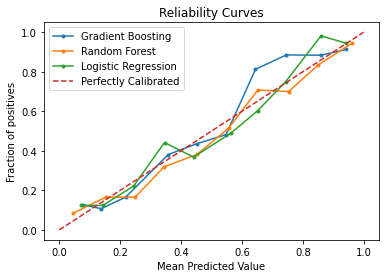

In [10]:
# Compute fraction of positives and mean predicted value for plot
fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y, rf_prob_result['1'], n_bins = 10)
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y, lr_prob_result['1'], n_bins = 10)
fraction_of_positives_gb, mean_predicted_value_gb = calibration_curve(y, gb_prob_result['1'], n_bins = 10)

plt.plot(mean_predicted_value_gb, fraction_of_positives_gb, marker = '.', label = 'Gradient Boosting')
plt.plot(mean_predicted_value_rf, fraction_of_positives_rf, marker = '.', label = 'Random Forest')
plt.plot(mean_predicted_value_lr, fraction_of_positives_lr, marker = '.', label = 'Logistic Regression')
plt.plot([0,1], [0,1], linestyle = '--',label = 'Perfectly Calibrated')

plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of positives')
plt.title('Reliability Curves')
plt.legend()
plt.show()

Calibration diagrams show how well calibrated the predicted probabilities of the model are with the true distribution of the class in data. The closer the plot is to the main diagonal, the better calibrated the probabilities of the model are. If the curves is below the main diagonal, the model has overforcast(the probabilities are too large). On the other hand if the curve is above the main diagonal,  the model has underforcast(the probabilities are too small).


**Inference from Calibration Curves:** 
Gradient Boosting model is the most calibrated with a plot that almost overlaps with the main diagonal(perfect calibration line) for mean predicted value between 0.2 and 0.6. Random Forest model overforcasts as its curve lies below the diagonal between mean predicted values slightly above 0.2 and 0.8. Logistic Regression model also overforcasts heavily for mean predicted value slightly below 0.6. None of the models show very poor performance and this can be because we performed nested cross validation before reporting the results.

---
### Exercise 2 - Machine Learning

#### 2.1. Suppose there is a Multi-Layer Perceptron (MLP) composed of one input layer with *eight* neurons, followed by one hidden layer with *30* artificial neurons, and one output layer with *three* artificial neurons. All artificial neurons use the ReLU activation function.

##### 2.1.a) Deduce the shape of input matrix $X$, hidden layer’s weight vector $W_h$, bias vector $b_h$ and the shape of the network’s output matrix $Y$.

#### 2.2. What are principle and unavoidable limitations of the backpropagation (BP)?

##### 2.1.b) Write the equation that computes the network’s output matrix $Y$ as a function of $X$, $W_h$, $b_h$, $W_o$ and $b_o$.

#### 2.3. The shown figure is a *three* layer neural network

##### 2.3.a) Compute $h_1$, $h_2$, $o_1$, and the total error using ReLU units. 

*Note*: $b_1$, $b_2$ and $b_3$ represent the biases added to their respective units.

##### 2.3.b) Calculate the updates of the network weights $w_1, \dots , w_6$ and bias terms $b_1$, $b_2$, $b_3$ using backpropagation. Assume a learning rate of $1$ for the
sake of simplicity. 

*Note*: Remember that a bias term is equivalent to a weighted constant input 1.

In [ ]:
!wget[](https://raw.githubusercontent.com/FabriceBeaumont/4216_Biomedical_DS_and_AI/main/Sheet8/sheet8_NN_sketch.png)

/bin/bash: -c: line 0: syntax error near unexpected token `https://raw.githubusercontent.com/FabriceBeaumont/4216_Biomedical_DS_and_AI/main/Sheet8/sheet8_NN_sketch.png'
/bin/bash: -c: line 0: `wget[](https://raw.githubusercontent.com/FabriceBeaumont/4216_Biomedical_DS_and_AI/main/Sheet8/sheet8_NN_sketch.png)'


With:
- $i_1 = 0.5$, $i_2 = 0.8$
- $w_1 = 0.15$, $w_2 = 0.2$, $w_3 = 0.25$, $w_4 = 0.3$, $w_5 = 0.4$, $w_6 = 0.55$
- $b_1 = 0.4$, $w_3 = 0.6$

And the activation function for $h_1$ and $h_2$ is the ReLU. The expected outputis $1$.

---
### Exercise 3- NN Programming

#### 3.1. Familiarize yourself with **tensorflow** and train a neural network with *two* hidden layers ($10$ and $8$ units respectively) and predict the label feature using the `titanic_survival_dataset.csv` dataset.


#### 3.2. Evaluate the performance of the neural network for the same dataset in a nested cross validation by optimizing the number of units in the second hidden layer in the inner cross validation. 

#### 3.3. How does the neural network perform in comparison to the models in the calibration curve from the previous task and plot the results alongside the other models in the calibration plot?